In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import os
import argparse
import time
from tqdm import trange
from tensorboardX import SummaryWriter
from collections import OrderedDict
from torchsummary import summary

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import RetinaMNIST
from medmnist import INFO, Evaluator

In [24]:
num_samples = 8
info = INFO["retinamnist"]
DataClass = getattr(medmnist, info['python_class'])
data_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=True)
train_loader = data.DataLoader(train_dataset, batch_size=num_samples, shuffle=True)

Using downloaded and verified file: /home/matthijs/.medmnist/retinamnist.npz


torch.Size([3, 28, 28])


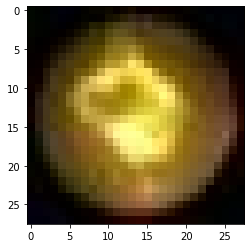

In [25]:
input, label = next(iter(train_loader))
print(input[7].shape)
plt.imshow(np.swapaxes(input[7],0,2))

In [28]:

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 5)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

def train(model, criterion, optimizer, device, writer, inputs, targets):
    total_loss = []
    global iteration

    model.train()
    g_layer1 = []
    g_layer2 = []
    # for batch_idx, (inputs, targets) in enumerate(train_loader):
    #     if batch_idx > num_batches: # for now, let's only look at two batches
    #         break
    optimizer.zero_grad()
    outputs = model(inputs.to(device))

    targets = torch.squeeze(targets, 1).long().to(device)
    loss = criterion(outputs, targets)

    total_loss.append(loss.item())
    writer.add_scalar('train_loss_logs', loss.item(), iteration)
    iteration += 1
    loss.backward()
    optimizer.step()
    g_layer1 = model.fc1.weight.grad
    g_layer2 = model.fc2.weight.grad
        # print(model.fc2.weight.grad[0])
    #     if batch_idx==0:
    #         G_layer1 = model.fc1.weight.grad
    #         G_layer2 = model.fc2.weight.grad
    #     else:
    #         G_layer1 += model.fc1.weight.grad
    #         G_layer2 += model.fc2.weight.grad

    # G_layer1 /= num_batches
    # G_layer2 /= num_batches
    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss, g_layer1, g_layer2


# Define model and optimizer
model = MyModel(3*28*28)
optimizer = optim.Adam(model.parameters())

# Define loss function
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()

iteration = 0
num_epochs = 1
num_batches = 5
gradients_layer1 = []
gradients_layer2 = []
# for epoch in trange(num_epochs):
inputs, targets = next(iter(train_loader))
epoch_loss, G_layer1, G_layer2 = train(model, criterion, optimizer, "cpu", writer, inputs, targets)

    # print(np.max(G_layer1)) #[1]/G_layer2[0])
gradients_layer1.append(G_layer1)
gradients_layer2.append(G_layer2)


TypeError: train() takes 7 positional arguments but 9 were given

In [6]:
def find_duplicate_values(arr: np.ndarray) -> np.ndarray:
    unique_vals, counts = np.unique(arr, return_counts=True)
    dup_vals = unique_vals[(counts>1)]#*(~np.isnan(unique_vals))]
    idcs = np.argwhere(np.array([(val  in dup_vals) for val in arr]))
    return idcs

In [19]:
from random import choice

def exact_label_reconstruction(loss_vector):
    if np.sum(loss_vector<0)==1:
        return np.argwhere(loss_vector<0)[0]
    else:
        return 0

#take batch 0 and epoch 0 
G1 = gradients_layer2[0][0][0,:]
G = np.zeros((5, G1.shape[0]))
r = np.zeros((5, G1.shape[0]))

for c in range(5):
    G[c] = gradients_layer2[0][0][c,:]
    r[c] = G[c]/G1

r_2 = r[1]

indices = []
exans = False
for c in range(1, 5):
    indices.append(find_duplicate_values(r[c]))
    if len(indices[-1])>0:
        print("disjoint index group", indices[-1])
        exans = True

if exans:
    for c in range(1, 5):
        for m in range(num_samples):
            j = choice(indices[c-1])
            # print(r[c][j])
            # print(r_2[j])
            #Y_lab[m] = exact_label_reconstruction(gradients_layer2[0][0][:,j])


    Y_lab = np.zeros(num_samples)
    for m in range(num_samples):
        continue
else:
    print("no exans")




no exans
